<a href="https://colab.research.google.com/github/ErfanTagh/fiftyone-examples/blob/master/OpenAi_Fiftyone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

Standard computer vision datasets have their limitations such as not being able to generalize many aspects of vision models. Creating image datasets would be laborious and have limitations, with restrictions over only a certain range of object categories.

To overcome these image label constraints, the team at OpenAI has designed its new neural network architecture **CLIP** (Contrastive Language-Image Pretraining) for Learning Transferable Visual Models From Natural Language Supervision.

In this example we are going to implement a simple CLIP model in **PyTorch** and visualize it in **Fiftyone**!

## **THE CLIP Algorithm In A Nutshell**

How **CLIP** works is very interesting. First, the images travels through the model and the model gives us logits of a certain likelihood of a text in an image as the output. So, the image goes into an encoding pipeline and then instead of the model giving us a certain prediction, we ask the model how likely is the image, a image of "dog" for instance?

CLIP does the following: The data (texts, images) goes through an encoder and the result of the encoders are mini-batch output vectors. So, for now we have two mini-batches, one for images and the other for texts. Since the images and texts were stacked on each other to represent their relative and close partner independently before travelling through their encoders, we know that the diagnol elements in the text-image matrices (I1 - T1 , I2 - T2 , I3 - T3 , ...) will be the right match.

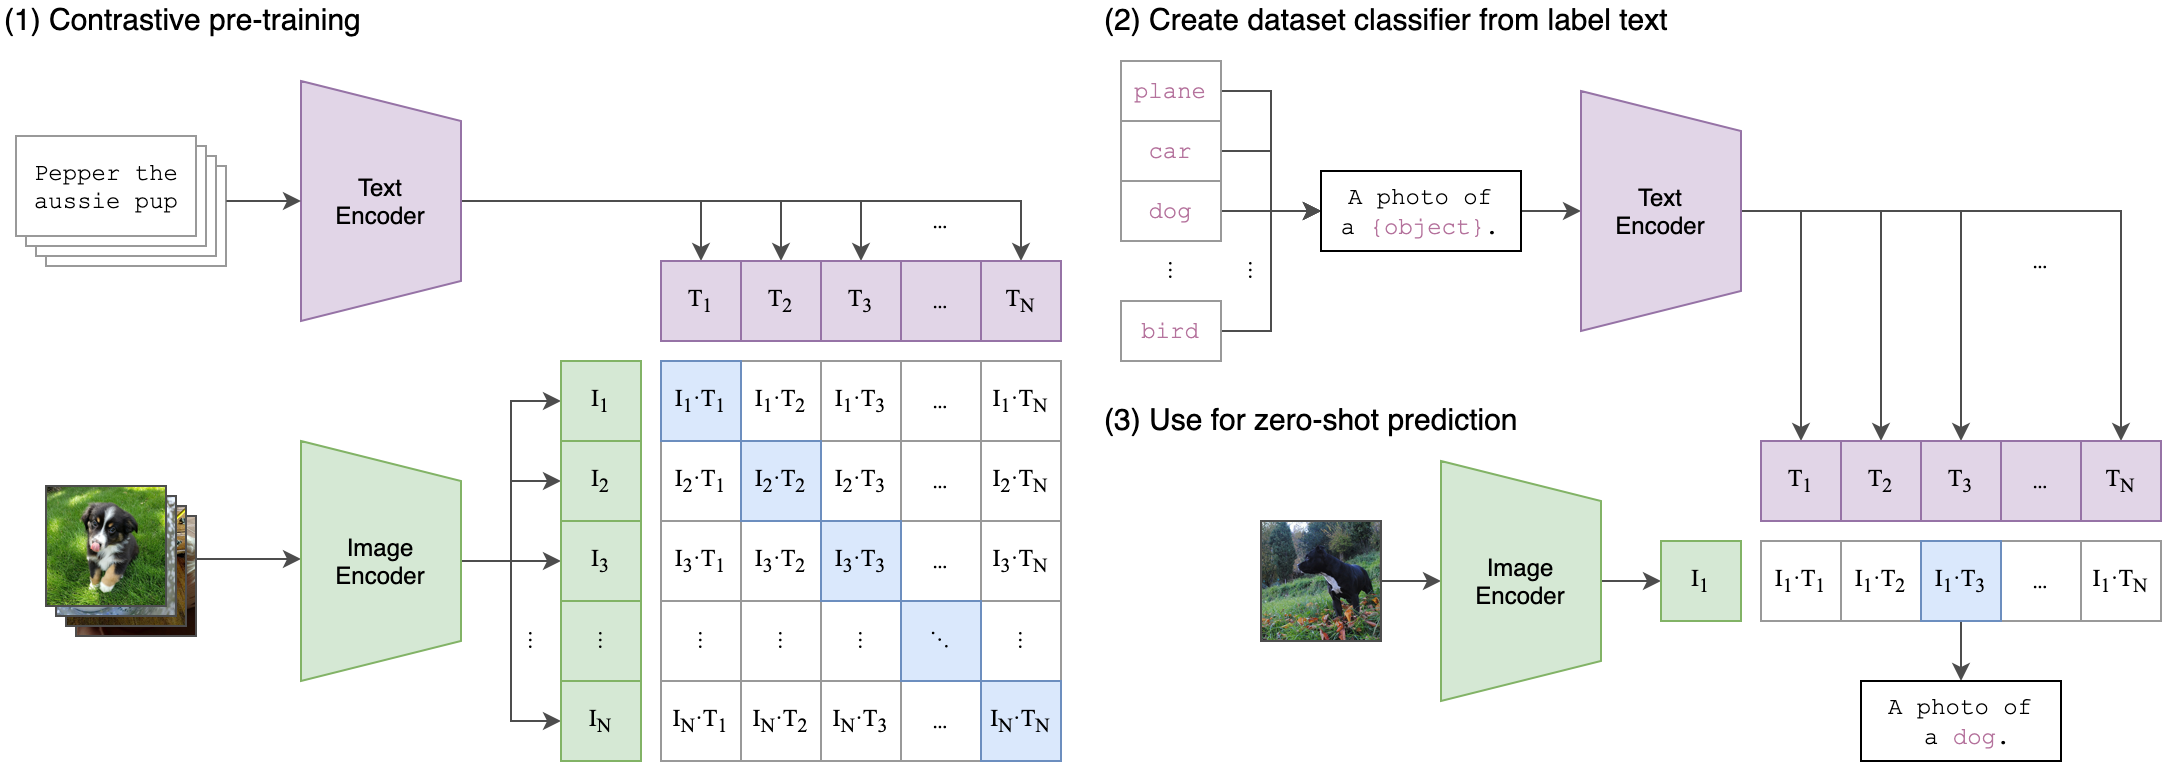

The approach that CLIP applies is called **contrastive learning**. It trains the data in a way that is maximum close to the right pairs (diagnol elements) and far away for the wrong (un-likely) pairs (other elements). It contrasts what we know will go together (meaning the diagnol elements) and constarsts what we know will not.

For each image vector we have a classification task in horizontal direction to determine the most suitable text. Similarly, for each text we have a classification task in vertical direction to determine the most suitable Image. The end goal is to find the inner product and interpret it as our logit.



```
# This is formatted as code
```

## **Congratulations for learning the logic, now it's coding time!**

In [ ]:
!pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

In [ ]:
!pip install gdown

In [ ]:
import sys
from pathlib import Path

!git clone https://github.com/openai/CLIP.git
clip_dir = Path(".").absolute() / "CLIP"
sys.path.append(str(clip_dir))
print(f"CLIP dir is: {clip_dir}")
# install with pip
!pip install CLIP/

import clip

In [ ]:
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
print(f"Model dir: {os.path.expanduser('~/.cache/clip')}")

We're almost done with setting up our lab, now let's get the images we need!

In [ ]:
!gdown --id 1_UcUblcH8u2b-H8xy3_HIYc-HY-7dv-2
!unzip clip_people.zip; rm clip_people.zip

If you're still with us then congratulations, now let's 
get to the exiting parts ...

In [ ]:
import os
# images we want to test are stored in folders with class names
class_names = sorted(os.listdir('./clip_people/'))
class_to_idx = {class_names[i]: i for i in range(len(class_names))}
class_names
annotations = class_to_idx
print(annotations)

In [ ]:
class_captions = [f"An image depicting a {x}" for x in class_names]
class_captions

In [ ]:
text_input = clip.tokenize(class_captions).to(device)
print(f"Tokens shape: {text_input.shape}")

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(f"Text features shape: {text_features.shape}")

In [ ]:
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to('cpu')
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to('cpu')

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    image *= image_std[:, None, None]    
    image += image_mean[:, None, None]
    return image

Let's take quick glance of our dataset to see what we got using **Fiftyone**

In [ ]:
!pip install fiftyone

In [ ]:
import fiftyone as fo

In [ ]:
name = "first_glance"
dataset_dir = "./clip_people/"

# Create the dataset
first_dataset = fo.Dataset.from_dir(dataset_dir, fo.types.ImageDirectory, name=name)


# View summary info about the dataset
print(first_dataset)

# Print the first few samples in the dataset
print(first_dataset.head())
session = fo.launch_app(first_dataset)

So far so good! Let's play around with CLIP and see whether we can fix those random labels!

In [ ]:
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to('cpu')
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to('cpu')

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    image *= image_std[:, None, None]    
    image += image_mean[:, None, None]
    return image

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
dataset = ImageFolder(root="./clip_people", transform=transform)
data_batches = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

In [ ]:
image_input, y_true = next(iter(data_batches))
image_input = image_input.to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()

Let's create a dictionary with full image address as key and a their representive name as the value

In [ ]:

annotations = {}
dataset_directory = './clip_people/**/*.jpg'
for img, (image, label_idx) in zip(sorted(glob.glob(dataset_directory)),dataset):
    cur_class = class_names[label_idx]    
    annotations[img] = cur_class    
    
print(annotations)

In [ ]:
import fiftyone as fo
import os



# Create sample, random dataset
sample_dataset = fo.Dataset(name="name_1")

# Add your samples to the dataset
for filepath in glob.glob(dataset_directory):
    print(filepath)
    label = annotations[filepath]

    sample = fo.Sample(filepath=filepath)

    # Store classification in a field name of your choice
    sample["ground_truth"] = fo.Classification(label=label)

    sample_dataset.add_sample(sample)
    

# View summary info about the dataset
print(sample_dataset)

# Print the first few samples in the dataset
print(sample_dataset.head())
session = fo.launch_app(sample_dataset)

We train our **CLIP** model our goal with the function below. This function calculates the dot product of the image and text vectors to give us the logit outputs.  

In [ ]:
def show_results(dataset_name, image_features, text_features, class_names):
    # depends on global var dataset

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    k = np.min([len(class_names), 5])
    top_probs, top_labels = text_probs.cpu().topk(k, dim=-1)
    text_probs = text_probs.cpu()
    
    list1 = class_names
    
    for (i,_),top_label in zip(annotations.items(),top_labels):
        annotations[i] = list1[top_label[0]]
        
        

        # Create dataset
    dataset_t = fo.Dataset(name=dataset_name)

    # Add your samples to the dataset
    for filepath in glob.glob(dataset_directory):
        print(filepath)
        label = annotations[filepath]

        sample = fo.Sample(filepath=filepath)

        # Store classification in a field name of your choice
        sample["ground_truth"] = fo.Classification(label=label)

        dataset_t.add_sample(sample)


    # View summary info about the dataset
    #print(dataset_t)

    # Print the first few samples in the dataset
    #print(dataset_t.head())
    session = fo.launch_app(dataset_t)    


In [ ]:
show_results("My-Data-1",image_features, text_features, class_names)

As you probably noticed, it didn't perform good at all. One reason might be that CLIP is trained mostly on Amercian names. Let's make the names more familiar and check whether it will give us a better result!

In [ ]:
class_names = ['James', 'Olivia', 'Emma']
class_captions = [f"An image depicting a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results("My-Data3", image_features, text_features, class_names)

Much, much look better now!

## **Male/Female Classification**

In [ ]:
class_names = ['male', 'female']
class_captions = [f"An image depicting a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results("Male_Female_2",image_features, text_features, class_names)

## **Presence of Any Sort of Particular Objects**

In [ ]:
class_names = ['microphone', 'chair', 'watch', 'glasses']
class_captions = [f"An image showing a {x}" for x in class_names]
text_input = clip.tokenize(class_captions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

show_results("Object_Presence",image_features, text_features, class_names)